In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

fn = 'D:/crs/src/NOPP_Utilities/data/SPOT-31232C_2023-09-14_2023-09-18_download.csv'

%run -i wave_stats.py

In [2]:
# read .csv, convert dashes to NaNs, remove rows with missing values
df = pd.read_csv(fn, na_values='-')
df = df[~df.iloc[:,5].isna()]

In [3]:
# Get a list of column numbers and names
for i, cname in enumerate( df.columns.tolist()):
    print(i,cname)

0 Battery Voltage (V)
1 Power (W)
2 Humidity (%rel)
3 Epoch Time
4 Significant Wave Height (m)
5 Peak Period (s)
6 Mean Period (s)
7 Peak Direction (deg)
8 Peak Directional Spread (deg)
9 Mean Direction (deg)
10 Mean Directional Spread (deg)
11 Latitude (deg)
12 Longitude (deg)
13 f_0
14 f_1
15 f_2
16 f_3
17 f_4
18 f_5
19 f_6
20 f_7
21 f_8
22 f_9
23 f_10
24 f_11
25 f_12
26 f_13
27 f_14
28 f_15
29 f_16
30 f_17
31 f_18
32 f_19
33 f_20
34 f_21
35 f_22
36 f_23
37 f_24
38 f_25
39 f_26
40 f_27
41 f_28
42 f_29
43 f_30
44 f_31
45 f_32
46 f_33
47 f_34
48 f_35
49 f_36
50 f_37
51 f_38
52 df_0
53 df_1
54 df_2
55 df_3
56 df_4
57 df_5
58 df_6
59 df_7
60 df_8
61 df_9
62 df_10
63 df_11
64 df_12
65 df_13
66 df_14
67 df_15
68 df_16
69 df_17
70 df_18
71 df_19
72 df_20
73 df_21
74 df_22
75 df_23
76 df_24
77 df_25
78 df_26
79 df_27
80 df_28
81 df_29
82 df_30
83 df_31
84 df_32
85 df_33
86 df_34
87 df_35
88 df_36
89 df_37
90 df_38
91 a1_0
92 a1_1
93 a1_2
94 a1_3
95 a1_4
96 a1_5
97 a1_6
98 a1_7
99 a1_8
100 a1

2023-09-17T22:45:00
Checking values: Theirs, ours
Hs (m): 0.949 0.9481778828958203
Peak period (s) 10.24 10.239606799098915
Mean period, TM01, TM02 (s) 4.896 4.979336474253237 4.304775702370635
Peak direction (deg): 130.303 130.3026601
Peak Directional Spread 36.829 36.82941604
Mean Direction (deg) 166.268 166.80670144146495
Mean Directional Spread (deg) 57.203 57.05425306487272
Spectral bandwidth () 0.5813399953134963
m0, m1, m2: 0.05619008110079999 0.011284652361081293 0.0030322053065265555
TM01, TM02 4.979336474253237 4.304775702370635
sigf 0.20544335767574115
SpecBw, Qp 0.5813399953134963 1.3240313379613362


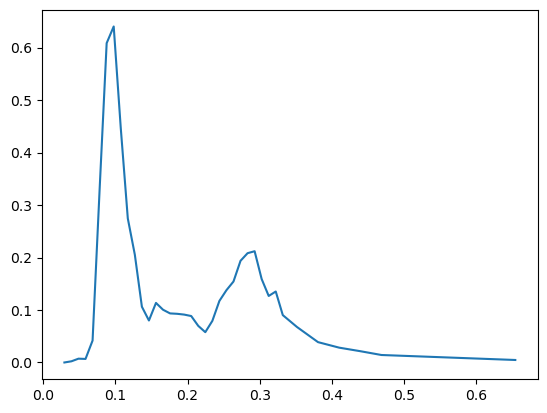

In [6]:
# check calcs for one set of data
i = 1
# calculate statistics
epoch = df.iloc[i,3]
dt = np.datetime64(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch)))
lat = df.iloc[i,11]
lon = df.iloc[i,12]
f = df.iloc[i,13:52].values.astype(np.float64)
delf = df.iloc[i,52:91].values.astype(np.float64)
a1 = df.iloc[i,91:130].values.astype(np.float64)
b1 = df.iloc[i,130:169].values.astype(np.float64)
a2 = df.iloc[i,169:208].values.astype(np.float64)
b2 = df.iloc[i,208:247].values.astype(np.float64)
S = df.iloc[i,247:286].values.astype(np.float64)
bdir = df.iloc[i,286:325].values.astype(np.float64)
dspd = df.iloc[i,325:364].values.astype(np.float64)
m0 = calc_m0_1d( S, f)
m1 = calc_m1_1d( S, f)
m2 = calc_m2_1d( S, f)
SpecBw = calc_SpecBw_1d( m0, m1, m2 )
Qp = calc_Qp_1d( S, f, m0 )

sigf = calc_sigmaf_1d( S, f )

plt.plot(f,S)
print(dt)
print('Checking values: Theirs, ours')
print('Hs (m):', df.iloc[i,4], calc_Hs_1d(S, f))
print('Peak period (s)', df.iloc[i,5], 1./f[np.argmax(S)] )
print('Mean period, TM01, TM02 (s)', df.iloc[i,6], m0/m1, np.sqrt(m0/m2))
print('Peak direction (deg):', df.iloc[i,7], bdir[np.argmax(S)])
print('Peak Directional Spread', df.iloc[i,8], dspd[np.argmax(S)])
print('Mean Direction (deg)', df.iloc[i,9], calc_weighted_theta_mean_a1b1( a1, b1, S, f))
print('Mean Directional Spread (deg)', df.iloc[i,10], calc_sigma_theta_a1b1( a1, b1, S, f))
print('Spectral bandwidth ()', np.sqrt(m0*m2/(m1*m1)-1.) )
print('m0, m1, m2:', m0, m1, m2)
print('TM01, TM02', m0/m1, np.sqrt(m0/m2))
print('sigf', sigf)
print('SpecBw, Qp',SpecBw, Qp )

In [10]:
# make arrays of bulk statistics
# (caution...re-using variable names)
# stuff provided by Spotter

# convert epoch time to datetime64[us]
nrows = df.shape[0]
epoch = df.iloc[:,3]
dta = np.empty((nrows,), dtype='datetime64[us]') 
for i, ep in enumerate( epoch ):
    dta[i] = np.datetime64( time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(ep) ) )

lon = df.iloc[:,12].values
lat = df.iloc[:,11].values
Hs = df.iloc[:,4].values
Tp = df.iloc[:,5].values
Dirp = df.iloc[:,7].values
Dsprd = df.iloc[:,8].values

# stuff we have to calculate
sigf = np.ones(nrows)*np.NaN

for i in range(nrows):
    f = df.iloc[i,13:52].values.astype(np.float64)
    S = df.iloc[i,247:286].values.astype(np.float64)
    sigf[i] = calc_sigmaf_1d( S, f ) 
    
#export to .csv    
pd.DataFrame((np.vstack((epoch, lon, lat, Hs, sigf, Tp, Dirp, Dsprd )).T).round(decimals=6)).to_csv('./wave_stats.csv',header=None, index=None)
